In [2]:
from reconstruction import reconstruct_volume_gpu
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os
import glob
import h5py
from tqdm.auto import tqdm
from lfm.util import create_projection_image, volume_to_gif

In [3]:
pn_rec = r"Y:/hpc/r/lfm2025/recordings"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'psf_filtered.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250425_1537_PSF_LB_redFB_1-10000_2d_without_coverslip_4
20250425_1457_PSF_LB_redFB_1-10000_2d_without_coverslip_x100_1
20250425_1415_PSF_LB_redFB_1-10000_2d_without_coverslip_y100_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3
20250425_1242_PSF_LB_redFB_1-10000_2d_without_coverslip_2
20250425_1217_PSF_LB_redFB_1-10000_2d_without_coverslip_1
20250425_1138_PSF_LB_background
20250412_1700_LB_redFB_1-10000_3d_with coverslip_1
20250412_1656_LB_redFB_1-5000_3d_with coverslip_2
20250412_1654_LB_redFB_1-5000_3d_with coverslip_1
20250412_1651_LB_redFB_1-1000_3d_with coverslip_2
20250412_1649_LB_redFB_1-1000_3d_with coverslip_1
20250412_1604_PSF_LB_redFB_1-5000_withcoverslip_1
20250412_1539_PSF_LB_redFB_1-1000_withcoverslip_2
20250412_1513_PSF_LB_redFB_1-1000_withcoverslip_1


In [17]:
pn_rec = r"Y:/hpc/r/lfm2025/recordings"
dataset_name = "20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3"
fn = os.path.join(pn_rec, dataset_name, 'psf_filtered.h5')
with h5py.File(fn, 'r') as f:
    # print(f.keys())
    psf = np.array(f['psf'])
    psf_filtered = np.array(f["psf_clean"])
    bg = np.array(f["bg"])



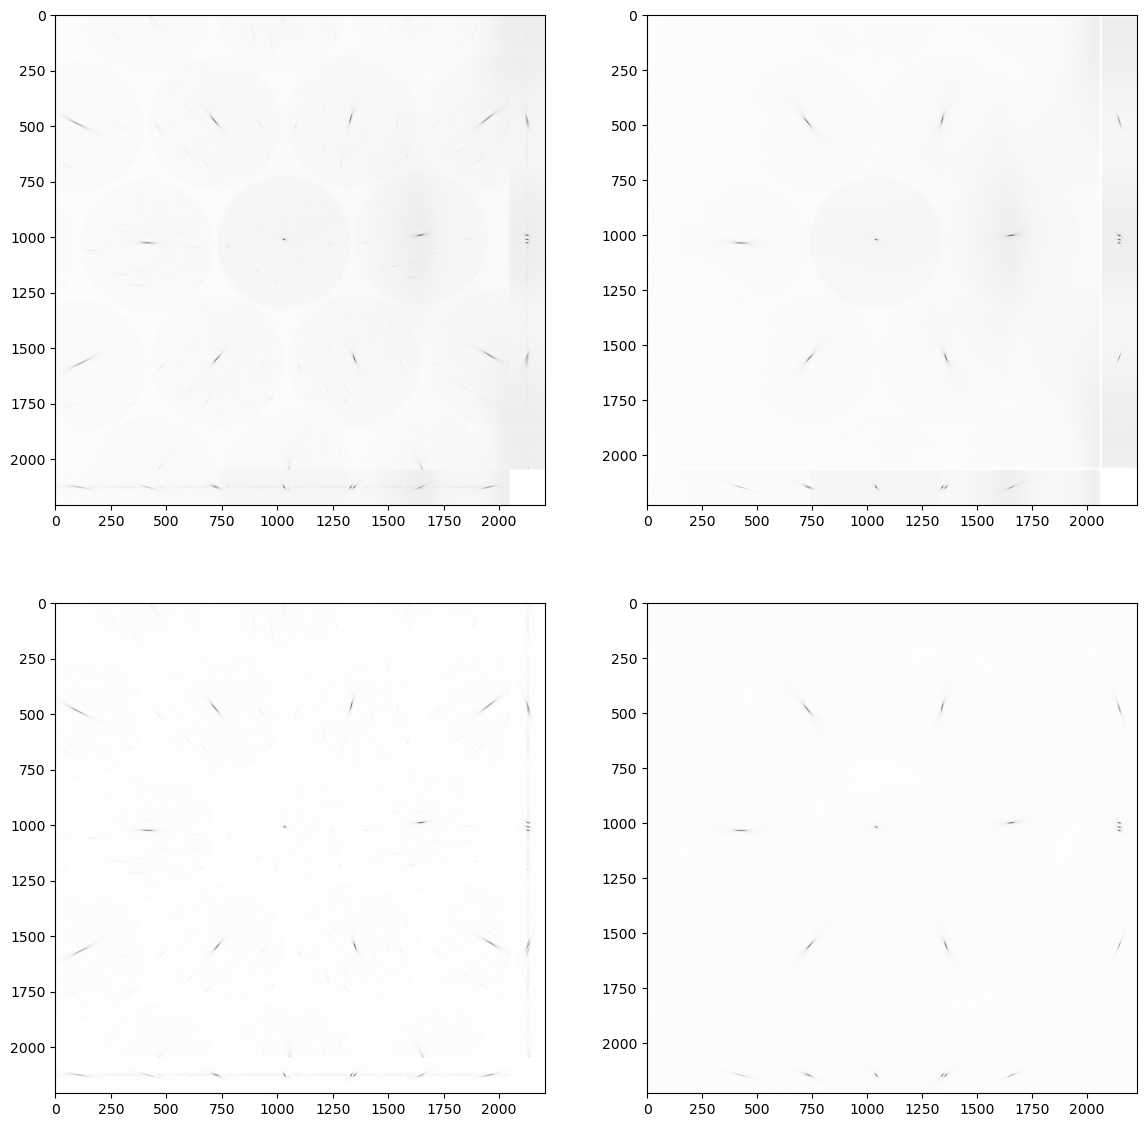

In [18]:
fig, ax = plt.subplots(2,2, figsize=(14, 14))
ax[0,0].imshow(create_projection_image(psf,np.max,pad=0), cmap='binary')
ax[0,1].imshow(create_projection_image(psf_filtered,np.max,pad=10), cmap='binary')
ax[1,0].imshow(create_projection_image(psf-bg,np.max,pad=0), cmap='binary')
ax[1,1].imshow(create_projection_image(psf_filtered-bg,np.max,pad=10), cmap='binary')

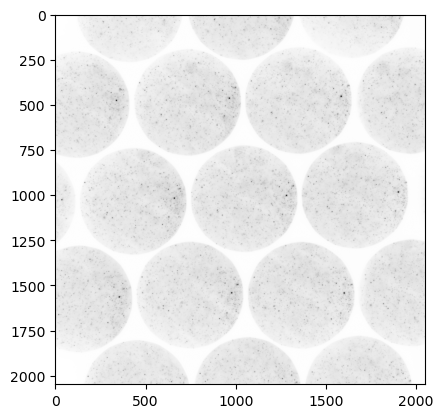

In [19]:
dataset_name = "20250412_1651_LB_redFB_1-1000_3d_with coverslip_2"
fn = os.path.join(pn_rec, dataset_name, 'psf.h5')
with h5py.File(fn, 'r') as f:
    imgs = np.array(f["psf"])
img = imgs[2,:,:]
plt.imshow(img, cmap='binary')

(array([3.83000e+04, 3.83611e+05, 2.44120e+05, 5.44890e+04, 2.71570e+04,
        1.75830e+04, 1.51060e+04, 1.55390e+04, 1.69820e+04, 2.39830e+04,
        3.03240e+04, 3.50560e+04, 4.30930e+04, 5.26950e+04, 6.23380e+04,
        7.10930e+04, 8.02510e+04, 9.34710e+04, 1.06973e+05, 1.24180e+05,
        1.38457e+05, 1.66374e+05, 1.94495e+05, 2.20596e+05, 2.29635e+05,
        2.28781e+05, 2.17725e+05, 1.98055e+05, 1.73559e+05, 1.47378e+05,
        1.18992e+05, 1.02478e+05, 8.30840e+04, 6.67270e+04, 5.41720e+04,
        4.40460e+04, 3.59110e+04, 2.94740e+04, 2.49720e+04, 2.07290e+04,
        1.64270e+04, 1.49720e+04, 1.27140e+04, 1.13460e+04, 9.75200e+03,
        8.56100e+03, 7.45000e+03, 6.49100e+03, 5.82600e+03, 5.22400e+03,
        4.71800e+03, 4.00900e+03, 3.80400e+03, 3.55300e+03, 3.14100e+03,
        2.83400e+03, 2.49500e+03, 2.35200e+03, 2.19600e+03, 1.95700e+03,
        1.82400e+03, 1.62600e+03, 1.58000e+03, 1.48200e+03, 1.36600e+03,
        1.34500e+03, 1.25500e+03, 1.18000e+03, 1.04

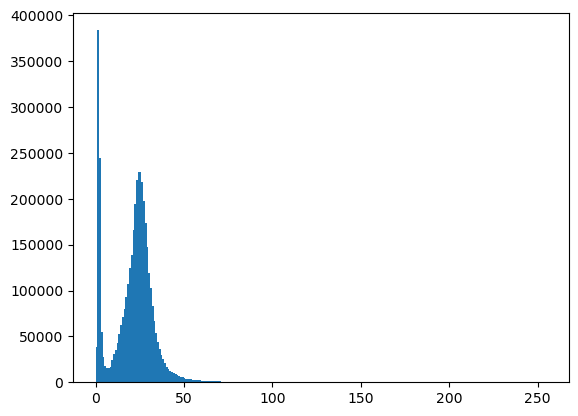

In [6]:
plt.hist(img.flatten(), bins=256)

In [23]:
psf1 = psf_filtered-bg
for z in range(psf.shape[0]):
    psf1[z,:,:] = psf1[z,:,:]/psf1[z,:,:].sum()
vol, loss, mip = reconstruct_volume_gpu(img,psf1,roi_size=200, n_iter=40,plot=True)

Initializing memory
Finished initializing memory


Main loop:   0%|          | 0/40 [00:00<?, ?it/s]

Forward Projection:   0%|          | 0/160 [00:00<?, ?it/s]

Back Projection:   0%|          | 0/160 [00:00<?, ?it/s]

In [24]:
from lfm.util import volume_to_gif, create_projection_image

volume_to_gif(mip.get(),gif_path="output_roi200.gif", cmap="gray")

  0%|          | 0/40 [00:00<?, ?it/s]

GIF saved to: output_roi200.gif


(160, 2048, 2048)

  0%|          | 0/64 [00:00<?, ?it/s]

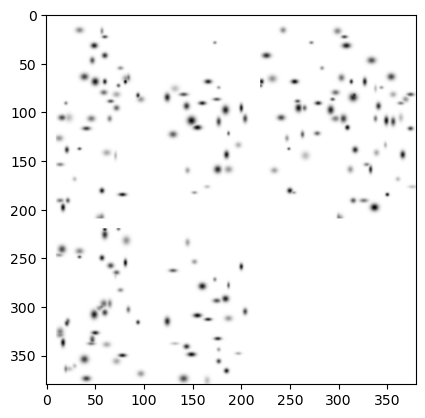

In [25]:
sparseness = 0.00001
intensity_dist = (50, 200)
sigma_dist = (1, 3)

sim_vol = np.zeros_like(vol)
depth, height, width = sim_vol.shape
n_gauss = int(depth * height * width * sparseness)
positions = np.random.rand(n_gauss, 3) * np.array([depth, height, width])
intensities = np.random.uniform(intensity_dist[0], intensity_dist[1], n_gauss)
sigmas = np.random.uniform(sigma_dist[0], sigma_dist[1], (n_gauss, 3))
z_indices, y_indices, x_indices = cp.mgrid[:depth, :height, :width]
# Add each Gaussian to the volume
for i in tqdm(range(n_gauss)):
    z_pos, y_pos, x_pos = positions.astype(np.int16)[i]
    sigma_z, sigma_y, sigma_x = sigmas[i]
    intensity = intensities[i]

    # Calculate 3D Gaussian
    gaussian = intensity * cp.exp(
        -((z_indices - z_pos) ** 2 / (2 * sigma_z ** 2) +
          (y_indices - y_pos) ** 2 / (2 * sigma_y ** 2) +
          (x_indices - x_pos) ** 2 / (2 * sigma_x ** 2))
    )

    # Add to volume
    sim_vol += gaussian

plt.imshow(create_projection_image(sim_vol.get(),np.max, pad=10), cmap='binary')

  0%|          | 0/160 [00:00<?, ?it/s]

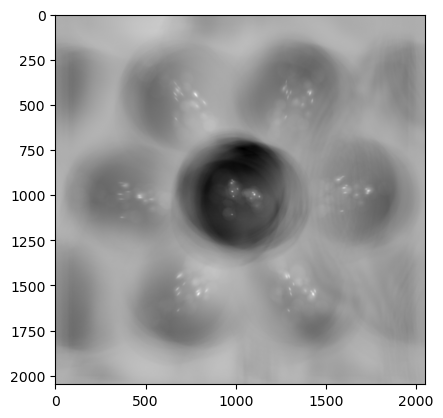

In [27]:
from cupyx.scipy.signal import fftconvolve
sim_img = cp.zeros_like(img)
slice_temp = cp.zeros_like(img)
roi_size = sim_vol.shape[1]
xy_pad = (psf.shape[1]-roi_size)//2
psf_gpu = cp.asarray(psf1)
for z in tqdm(range(psf.shape[0])):
    slice_temp[xy_pad:xy_pad+roi_size,xy_pad:xy_pad+roi_size] = sim_vol[z,:,:]
    forward_pass = fftconvolve(slice_temp, psf_gpu[z,:,:],  mode="same")
    sim_img += forward_pass
plt.imshow(sim_img.get(), cmap='binary')

In [24]:
type(psf)


numpy.ndarray

In [28]:
psf.shape

(160, 2048, 2048)

In [ ]:
def generate_random_gaussians_3d(shape,
                                 sparseness=0.01,  # fraction of voxels that contain Gaussians
                                 intensity_dist=(50, 200),  # (min, max) for uniform distribution
                                 sigma_dist=(2, 5),  # (min, max) for standard deviations
                                 seed=None):
    """
    Generate a 3D volume with randomly placed 3D Gaussian kernels.

    Parameters:
    -----------
    shape: tuple
        Shape of the output volume (depth, height, width)
    sparseness: float
        Fraction of voxels that contain Gaussian kernels (0-1)
    intensity_dist: tuple
        (min, max) for uniform intensity distribution
    sigma_dist: tuple
        (min, max) for standard deviation of Gaussians
    seed: int
        Random seed for reproducibility

    Returns:
    --------
    volume: cp.ndarray
        3D volume with Gaussian kernels
    """
    if seed is not None:
        np.random.seed(seed)
        cp.random.seed(seed)

    # Create empty volume
    volume = cp.zeros(shape, dtype=cp.float32)
    depth, height, width = shape

    # Calculate number of Gaussians based on sparseness
    total_voxels = depth * height * width
    n_gaussians = int(total_voxels * sparseness)

    # Generate random positions
    positions = np.random.rand(n_gaussians, 3) * np.array([depth, height, width])

    # Generate random intensities and sigmas
    intensities = np.random.uniform(intensity_dist[0], intensity_dist[1], n_gaussians)
    sigmas = np.random.uniform(sigma_dist[0], sigma_dist[1], (n_gaussians, 3))

    # Create coordinate grids
    z_indices, y_indices, x_indices = cp.mgrid[:depth, :height, :width]

    # Add each Gaussian to the volume
    for i in range(n_gaussians):
        z_pos, y_pos, x_pos = positions[i]
        sigma_z, sigma_y, sigma_x = sigmas[i]
        intensity = intensities[i]

        # Calculate 3D Gaussian
        gaussian = intensity * cp.exp(
            -((z_indices - z_pos) ** 2 / (2 * sigma_z ** 2) +
              (y_indices - y_pos) ** 2 / (2 * sigma_y ** 2) +
              (x_indices - x_pos) ** 2 / (2 * sigma_x ** 2))
        )

        # Add to volume
        volume += gaussian

    return volume

In [ ]:
def create_projection_image(volume, projection_func=None, pad=10):
    """
    Creates a 2D image showing projections of a 3D volume along all three axes.

    Parameters:
    -----------
    volume : cp.ndarray or np.ndarray
        3D input volume of shape (depth, height, width)
    projection_func : callable, optional
        Function to use for projection (e.g., np.max, np.mean, np.sum)
        Defaults to max if None is provided
    pad : int
        Padding between the projections

    Returns:
    --------
    projection_image : same type as volume
        2D image showing all three projections arranged with:
        - xy (axial) in the center
        - xz at the bottom
        - yz on the right side
    """
    # Default to max projection if no function provided
    if projection_func is None:
        if isinstance(volume, cp.ndarray):
            projection_func = cp.max
        else:
            projection_func = np.max

    # Get dimensions
    depth, height, width = volume.shape

    # Calculate output dimensions with padding
    output_height = height + depth + 2 * pad
    output_width = width + depth + 2 * pad

    # Create empty output image (using same array type as input)
    if isinstance(volume, cp.ndarray):
        output = cp.zeros((output_height, output_width), dtype=volume.dtype)
    else:
        output = np.zeros((output_height, output_width), dtype=volume.dtype)

    # Create projections
    xy_proj = projection_func(volume, axis=0)  # Top-down view
    xz_proj = projection_func(volume, axis=1)  # Front view
    yz_proj = projection_func(volume, axis=2)  # Side view

    # Place projections in output image
    # XY projection (center)
    output[pad:pad+height, pad:pad+width] = xy_proj

    # XZ projection (bottom)
    output[pad+height+pad:pad+height+pad+depth, pad:pad+width] = xz_proj

    # YZ projection (right side) - needs transpose to align correctly
    output[pad:pad+height, pad+width+pad:pad+width+pad+depth] = yz_proj.T

    return output